![lop](../../images/logo_diive1_128px.png)

<span style='font-size:40px; display:block;'>
<b>
    Random forest gap-filling
</b>
</span>

---
**Notebook version**: `2.1` (11 Jun 2024)  
**Author**: Lukas Hörtnagl (holukas@ethz.ch)  

</br>

# **Imports**
- This notebook uses `diive` ([source code](https://gitlab.ethz.ch/diive/diive)) to check eddy covariance fluxes for quality

In [1]:
import importlib.metadata
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from diive.core.io.files import save_parquet, load_parquet
from diive.core.plotting.timeseries import TimeSeries  # For simple (interactive) time series plotting
from diive.core.dfun.stats import sstats  # Time series stats
from diive.core.plotting.heatmap_datetime import HeatmapDateTime
from diive.pkgs.gapfilling.randomforest_ts import RandomForestTS
import warnings
warnings.filterwarnings('ignore')
version_diive = importlib.metadata.version("diive")
print(f"diive version: v{version_diive}")

diive version: v0.85.5


# **Variables**

## Target variable
- Needed: the fully quality-controlled flux before gap-filling

In [2]:
TARGET_COL = 'FN2O_L3.1_L3.3_CUT_50_QCF'

## Features

In [3]:
# Management variables
MGMT_VARS = [
    "TIMESINCE_MGMT_FERT_MIN_FOOTPRINT", "TIMESINCE_MGMT_FERT_ORG_FOOTPRINT",
    "TIMESINCE_MGMT_GRAZING_FOOTPRINT", "TIMESINCE_MGMT_MOWING_FOOTPRINT",
    "TIMESINCE_MGMT_SOILCULTIVATION_FOOTPRINT", "TIMESINCE_MGMT_SOWING_FOOTPRINT",
    "TIMESINCE_MGMT_PESTICIDE_HERBICIDE_FOOTPRINT", "TIMESINCE_PREC_RAIN_TOT_GF1_0.5_1"
]

# Already lagged variants of SWC, TS and PRECIP
AGG_VARS = [
    # SWC
    "SWC_GF1_0.15_1_gfXG_MEAN3H",
    ".SWC_GF1_0.15_1_gfXG_MEAN3H-24", ".SWC_GF1_0.15_1_gfXG_MEAN3H-18",
    ".SWC_GF1_0.15_1_gfXG_MEAN3H-12", ".SWC_GF1_0.15_1_gfXG_MEAN3H-6",
    # TS
    "TS_GF1_0.04_1_gfXG_MEAN3H",
    ".TS_GF1_0.04_1_gfXG_MEAN3H-24", ".TS_GF1_0.04_1_gfXG_MEAN3H-18",
    ".TS_GF1_0.04_1_gfXG_MEAN3H-12", ".TS_GF1_0.04_1_gfXG_MEAN3H-6",
    "TS_GF1_0.15_1_gfXG_MEAN3H",
    ".TS_GF1_0.15_1_gfXG_MEAN3H-24", ".TS_GF1_0.15_1_gfXG_MEAN3H-18",
    ".TS_GF1_0.15_1_gfXG_MEAN3H-12", ".TS_GF1_0.15_1_gfXG_MEAN3H-6",
    "TS_GF1_0.4_1_gfXG_MEAN3H",
    ".TS_GF1_0.4_1_gfXG_MEAN3H-24", ".TS_GF1_0.4_1_gfXG_MEAN3H-18",
    ".TS_GF1_0.4_1_gfXG_MEAN3H-12", ".TS_GF1_0.4_1_gfXG_MEAN3H-6",
    # PRECIP
    "PREC_RAIN_TOT_GF1_0.5_1_MEAN3H",
    ".PREC_RAIN_TOT_GF1_0.5_1_MEAN3H-24", ".PREC_RAIN_TOT_GF1_0.5_1_MEAN3H-18",
    ".PREC_RAIN_TOT_GF1_0.5_1_MEAN3H-12", ".PREC_RAIN_TOT_GF1_0.5_1_MEAN3H-6"
]

METEO_VARS = [
    "TS_GF1_0.04_1_gfXG",
    "TS_GF1_0.15_1_gfXG",
    "TS_GF1_0.4_1_gfXG",
    "SWC_GF1_0.15_1_gfXG", 
    "PREC_RAIN_TOT_GF1_0.5_1"
]

FEATURES = METEO_VARS + AGG_VARS + MGMT_VARS
FEATURES

['TS_GF1_0.04_1_gfXG',
 'TS_GF1_0.15_1_gfXG',
 'TS_GF1_0.4_1_gfXG',
 'SWC_GF1_0.15_1_gfXG',
 'PREC_RAIN_TOT_GF1_0.5_1',
 'SWC_GF1_0.15_1_gfXG_MEAN3H',
 '.SWC_GF1_0.15_1_gfXG_MEAN3H-24',
 '.SWC_GF1_0.15_1_gfXG_MEAN3H-18',
 '.SWC_GF1_0.15_1_gfXG_MEAN3H-12',
 '.SWC_GF1_0.15_1_gfXG_MEAN3H-6',
 'TS_GF1_0.04_1_gfXG_MEAN3H',
 '.TS_GF1_0.04_1_gfXG_MEAN3H-24',
 '.TS_GF1_0.04_1_gfXG_MEAN3H-18',
 '.TS_GF1_0.04_1_gfXG_MEAN3H-12',
 '.TS_GF1_0.04_1_gfXG_MEAN3H-6',
 'TS_GF1_0.15_1_gfXG_MEAN3H',
 '.TS_GF1_0.15_1_gfXG_MEAN3H-24',
 '.TS_GF1_0.15_1_gfXG_MEAN3H-18',
 '.TS_GF1_0.15_1_gfXG_MEAN3H-12',
 '.TS_GF1_0.15_1_gfXG_MEAN3H-6',
 'TS_GF1_0.4_1_gfXG_MEAN3H',
 '.TS_GF1_0.4_1_gfXG_MEAN3H-24',
 '.TS_GF1_0.4_1_gfXG_MEAN3H-18',
 '.TS_GF1_0.4_1_gfXG_MEAN3H-12',
 '.TS_GF1_0.4_1_gfXG_MEAN3H-6',
 'PREC_RAIN_TOT_GF1_0.5_1_MEAN3H',
 '.PREC_RAIN_TOT_GF1_0.5_1_MEAN3H-24',
 '.PREC_RAIN_TOT_GF1_0.5_1_MEAN3H-18',
 '.PREC_RAIN_TOT_GF1_0.5_1_MEAN3H-12',
 '.PREC_RAIN_TOT_GF1_0.5_1_MEAN3H-6',
 'TIMESINCE_MGMT_FERT_MIN_FOOT

# **Load data**

## Load main data

In [4]:
SOURCEDIR = r"../30_MERGE_DATA"
FILENAME = r"33.5_CH-CHA_IRGA+QCL+LGR+M10+MGMT_Level-1_eddypro_fluxnet_2005-2024.parquet"
FILEPATH = Path(SOURCEDIR) / FILENAME
print(f"Data will be loaded from the following file:\n{FILEPATH}")
maindf = load_parquet(filepath=FILEPATH)
maindf = maindf[FEATURES].copy()
maindf

Data will be loaded from the following file:
..\30_MERGE_DATA\33.5_CH-CHA_IRGA+QCL+LGR+M10+MGMT_Level-1_eddypro_fluxnet_2005-2024.parquet
Loaded .parquet file ..\30_MERGE_DATA\33.5_CH-CHA_IRGA+QCL+LGR+M10+MGMT_Level-1_eddypro_fluxnet_2005-2024.parquet (0.501 seconds).
    --> Detected time resolution of <30 * Minutes> / 30min 


,TS_GF1_0.04_1_gfXG,TS_GF1_0.15_1_gfXG,TS_GF1_0.4_1_gfXG,SWC_GF1_0.15_1_gfXG,PREC_RAIN_TOT_GF1_0.5_1,SWC_GF1_0.15_1_gfXG_MEAN3H,...,TIMESINCE_MGMT_GRAZING_FOOTPRINT,TIMESINCE_MGMT_MOWING_FOOTPRINT,TIMESINCE_MGMT_SOILCULTIVATION_FOOTPRINT,TIMESINCE_MGMT_SOWING_FOOTPRINT,TIMESINCE_MGMT_PESTICIDE_HERBICIDE_FOOTPRINT,TIMESINCE_PREC_RAIN_TOT_GF1_0.5_1
TIMESTAMP_MIDDLE,,,,,,,,,,,,,
2005-01-01 00:15:00,1.014525,2.907254,4.007686,47.854301,0.0,NaN,...,17.0,88.0,278.0,278.0,467.0,1.0
2005-01-01 00:45:00,1.029936,2.907254,4.007686,47.854301,0.0,NaN,...,17.0,88.0,278.0,278.0,467.0,2.0
2005-01-01 01:15:00,1.003078,2.903765,4.077782,47.627148,0.1,NaN,...,17.0,88.0,278.0,278.0,467.0,0.0
2005-01-01 01:45:00,1.056877,2.903765,4.077782,47.627148,0.0,NaN,...,17.0,88.0,278.0,278.0,467.0,1.0
2005-01-01 02:15:00,0.963062,2.932330,3.979915,48.188377,0.1,NaN,...,17.0,88.0,278.0,278.0,467.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-31 21:45:00,3.474346,4.437078,5.528727,52.459871,0.0,52.381843,...,42.0,131.0,194.0,1209.0,287.0,380.0
2024-12-31 22:15:00,3.428224,4.440415,5.521962,52.633365,0.0,52.423854,...,42.0,131.0,194.0,1209.0,287.0,381.0
2024-12-31 22:45:00,3.384733,4.443751,5.523991,52.381308,0.0,52.496681,...,42.0,131.0,194.0,1209.0,287.0,382.0


## Load quality-controlled fluxes (not gap-filled)

In [5]:
SOURCEDIR = r""
FILENAME = r"51.1_FluxProcessingChain_L4.1_FN2O.parquet"
FILEPATH = Path(SOURCEDIR) / FILENAME
df = load_parquet(filepath=FILEPATH)
# [print(c) for c in df.columns if "FN2O" in c];
df = df[[TARGET_COL]].copy()
df

Loaded .parquet file 51.1_FluxProcessingChain_L4.1_FN2O.parquet (0.027 seconds).
    --> Detected time resolution of <30 * Minutes> / 30min 


,FN2O_L3.1_L3.3_CUT_50_QCF
TIMESTAMP_MIDDLE,
2012-01-01 00:15:00,NaN
2012-01-01 00:45:00,NaN
2012-01-01 01:15:00,NaN
2012-01-01 01:45:00,NaN
2012-01-01 02:15:00,NaN
...,...
2022-12-31 21:45:00,NaN
2022-12-31 22:15:00,NaN
2022-12-31 22:45:00,NaN


In [6]:
sstats(df[TARGET_COL])

,FN2O_L3.1_L3.3_CUT_50_QCF
STARTDATE,2012-01-01 00:15
ENDDATE,2022-12-31 23:45
PERIOD,4017 days 23:30:00
NOV,73484
MISSING,119380
MISSING_PERC,61.89854
MEAN,1.170834
MEDIAN,0.36404
SD,3.076644
VAR,9.465739


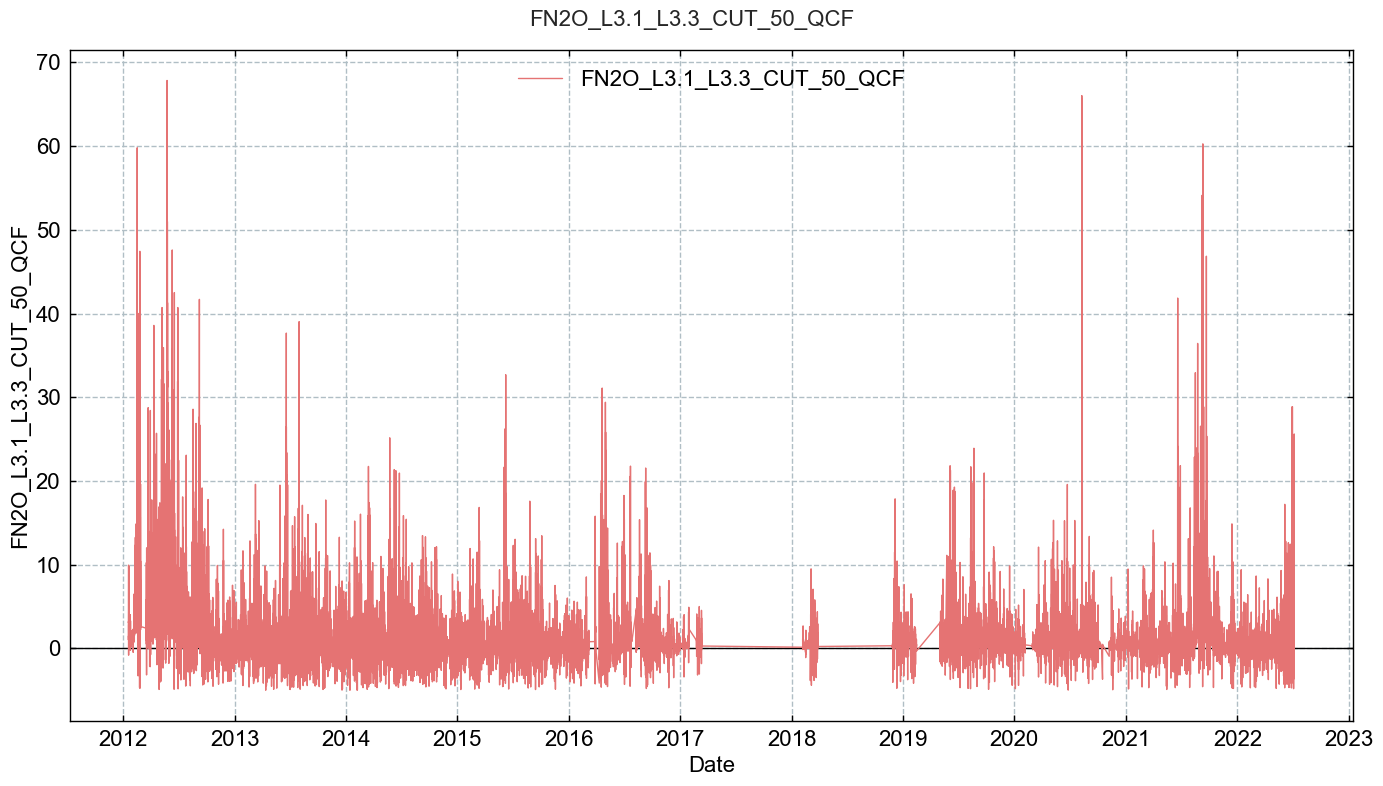

In [7]:
# TimeSeries(series=df[TARGET_COL]).plot_interactive()
TimeSeries(series=df[TARGET_COL]).plot()

# **Make subset for gap-filling**

In [8]:
subset = pd.concat([df, maindf], axis=1)
subset = subset.loc[(subset.index.year >= 2016) & (subset.index.year <= 2018)].copy()
subset

,FN2O_L3.1_L3.3_CUT_50_QCF,TS_GF1_0.04_1_gfXG,TS_GF1_0.15_1_gfXG,TS_GF1_0.4_1_gfXG,SWC_GF1_0.15_1_gfXG,PREC_RAIN_TOT_GF1_0.5_1,...,TIMESINCE_MGMT_GRAZING_FOOTPRINT,TIMESINCE_MGMT_MOWING_FOOTPRINT,TIMESINCE_MGMT_SOILCULTIVATION_FOOTPRINT,TIMESINCE_MGMT_SOWING_FOOTPRINT,TIMESINCE_MGMT_PESTICIDE_HERBICIDE_FOOTPRINT,TIMESINCE_PREC_RAIN_TOT_GF1_0.5_1
TIMESTAMP_MIDDLE,,,,,,,,,,,,,
2016-01-01 00:15:00,NaN,5.285700,5.288200,5.988200,45.325112,0.0,...,179.0,95.0,294.0,294.0,927.0,4.0
2016-01-01 00:45:00,NaN,5.281300,5.304900,6.011500,45.332228,0.0,...,179.0,95.0,294.0,294.0,927.0,5.0
2016-01-01 01:15:00,NaN,5.302400,5.257948,6.019800,45.340136,0.3,...,359.0,95.0,1373.0,1374.0,927.0,0.0
2016-01-01 01:45:00,0.275746,5.311000,5.314200,6.045200,45.355958,0.2,...,359.0,95.0,1373.0,1374.0,927.0,0.0
2016-01-01 02:15:00,NaN,5.322900,5.301300,6.023500,45.363871,0.0,...,179.0,95.0,294.0,294.0,927.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-31 21:45:00,NaN,5.388645,5.268411,6.094739,41.521091,0.0,...,428.0,70.0,999.0,102.0,2022.0,32.0
2018-12-31 22:15:00,NaN,5.169007,5.162627,6.040876,41.498699,0.0,...,428.0,70.0,999.0,102.0,2022.0,33.0
2018-12-31 22:45:00,NaN,5.123191,5.229537,6.268638,41.532082,0.0,...,428.0,70.0,999.0,102.0,2022.0,34.0


</br>

# **Gap-filling**

## Initialize random forest

In [11]:
# Random forest
rfts = RandomForestTS(
    input_df=subset,
    target_col=TARGET_COL,
    verbose=1,    
    features_lag=[-1, -1],    
    features_lag_stepsize=1,
    features_lag_exclude_cols=MGMT_VARS+AGG_VARS,
    include_timestamp_as_features=True,    
    add_continuous_record_number=True,
    sanitize_timestamp=True,
    n_estimators=3,
    random_state=42,
    min_samples_split=2,
    min_samples_leaf=1,
    perm_n_repeats=5,
    n_jobs=-1
)



Starting gap-filling for
FN2O_L3.1_L3.3_CUT_50_QCF
using <class 'sklearn.ensemble._forest.RandomForestRegressor'>

Adding new data columns ...
++ Added new columns with lagged variants for: ['TS_GF1_0.04_1_gfXG', 'TS_GF1_0.15_1_gfXG', 'TS_GF1_0.4_1_gfXG', 'SWC_GF1_0.15_1_gfXG', 'PREC_RAIN_TOT_GF1_0.5_1'] (lags between -1 and -1 with stepsize 1), no lagged variants for: ['FN2O_L3.1_L3.3_CUT_50_QCF', 'SWC_GF1_0.15_1_gfXG_MEAN3H', '.SWC_GF1_0.15_1_gfXG_MEAN3H-24', '.SWC_GF1_0.15_1_gfXG_MEAN3H-18', '.SWC_GF1_0.15_1_gfXG_MEAN3H-12', '.SWC_GF1_0.15_1_gfXG_MEAN3H-6', 'TS_GF1_0.04_1_gfXG_MEAN3H', '.TS_GF1_0.04_1_gfXG_MEAN3H-24', '.TS_GF1_0.04_1_gfXG_MEAN3H-18', '.TS_GF1_0.04_1_gfXG_MEAN3H-12', '.TS_GF1_0.04_1_gfXG_MEAN3H-6', 'TS_GF1_0.15_1_gfXG_MEAN3H', '.TS_GF1_0.15_1_gfXG_MEAN3H-24', '.TS_GF1_0.15_1_gfXG_MEAN3H-18', '.TS_GF1_0.15_1_gfXG_MEAN3H-12', '.TS_GF1_0.15_1_gfXG_MEAN3H-6', 'TS_GF1_0.4_1_gfXG_MEAN3H', '.TS_GF1_0.4_1_gfXG_MEAN3H-24', '.TS_GF1_0.4_1_gfXG_MEAN3H-18', '.TS_GF1_0.4_1_gfXG

</br>

## Feature reduction

In [12]:
rfts.reduce_features()


[ FEATURE REDUCTION ] Feature reduction based on permutation importance ...
[ FEATURE REDUCTION ] >>> Calculating feature importances (permutation importance, 5 repeats) ...
[ FEATURE REDUCTION ] >>> Setting threshold for feature rejection to 0.09112186088407467.

[ FEATURE REDUCTION ] >>> Accepted features and their importance:
                                              PERM_IMPORTANCE
.RECORDNUMBER                                        1.108052
TIMESINCE_MGMT_FERT_ORG_FOOTPRINT                    0.864362
TS_GF1_0.4_1_gfXG_MEAN3H                             0.739505
.TS_GF1_0.15_1_gfXG_MEAN3H-24                        0.677102
TIMESINCE_MGMT_FERT_MIN_FOOTPRINT                    0.556564
.TS_GF1_0.04_1_gfXG_MEAN3H-6                         0.461721
TIMESINCE_MGMT_SOWING_FOOTPRINT                      0.457237
.TS_GF1_0.15_1_gfXG_MEAN3H-6                         0.419482
.SWC_GF1_0.15_1_gfXG_MEAN3H-6                        0.410589
.TS_GF1_0.04_1_gfXG_MEAN3H-18                   

In [13]:
rfts.report_feature_reduction()


FEATURE REDUCTION

- Target variable: FN2O_L3.1_L3.3_CUT_50_QCF

- The random variable .RANDOM was added to the original features, used as benchmark for detecting relevant feature importances.

PERMUTATION IMPORTANCE (mean) across all splits of TimeSeriesSplit:

                                   PERM_IMPORTANCE   PERM_SD
.RECORDNUMBER                             1.108052  0.051654
TIMESINCE_MGMT_FERT_ORG_FOOTPRINT         0.864362  0.026744
TS_GF1_0.4_1_gfXG_MEAN3H                  0.739505  0.034418
.TS_GF1_0.15_1_gfXG_MEAN3H-24             0.677102  0.020291
TIMESINCE_MGMT_FERT_MIN_FOOTPRINT         0.556564  0.048287
...                                            ...       ...
.SEASON                                   0.001736  0.000279
.PREC_RAIN_TOT_GF1_0.5_1-1                0.001285  0.000030
.WEEK                                     0.000235  0.001441
.MONTH                                    0.000149  0.000029
.YEAR                                     0.000002  0.000031

[54

</br>

## Train model


Training final model ...
>>> Training model <class 'sklearn.ensemble._forest.RandomForestRegressor'> based on data between 2016-01-01 02:45:00 and 2018-12-31 20:15:00 ...
>>> Fitting model to training data ...
>>> Using model to predict target FN2O_L3.1_L3.3_CUT_50_QCF in unseen test data ...
>>> Using model to calculate permutation importance based on unseen test data ...
>>> Plotting feature importances (permutation importance) ...
>>> Calculating prediction scores based on predicting unseen test data of FN2O_L3.1_L3.3_CUT_50_QCF ...
>>> Plotting observed and predicted values ...


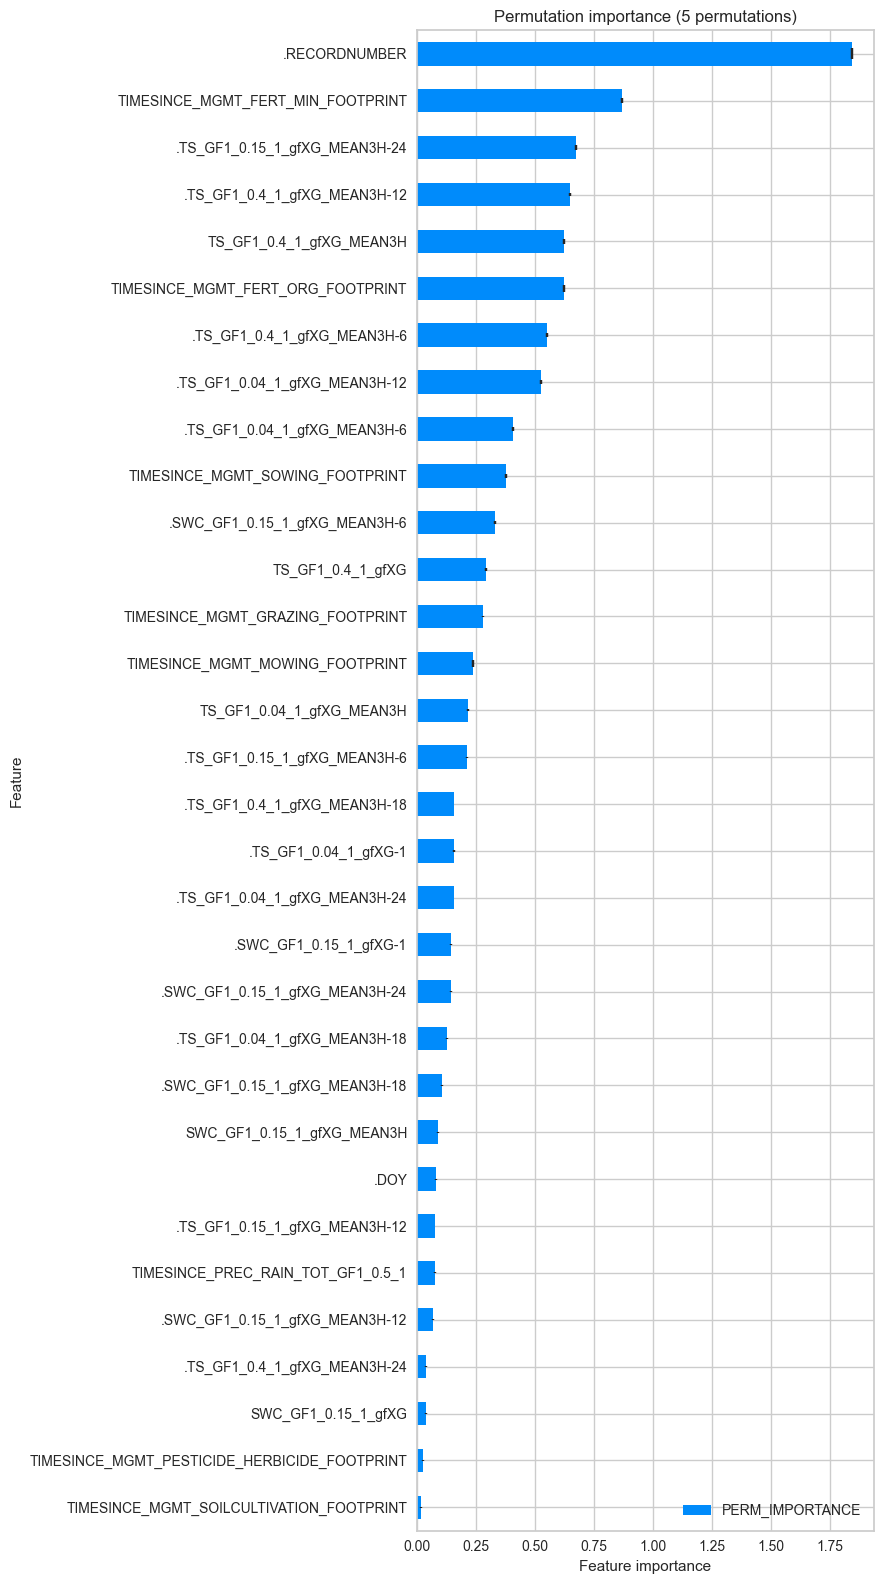

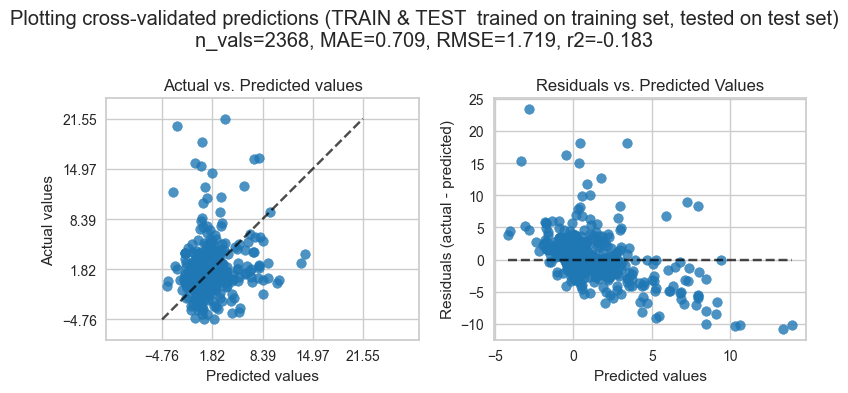

>>> Plotting residuals and prediction error ...


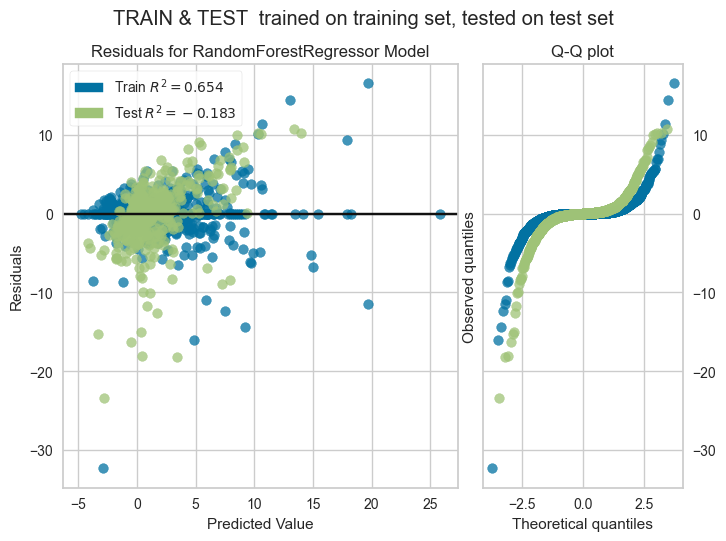

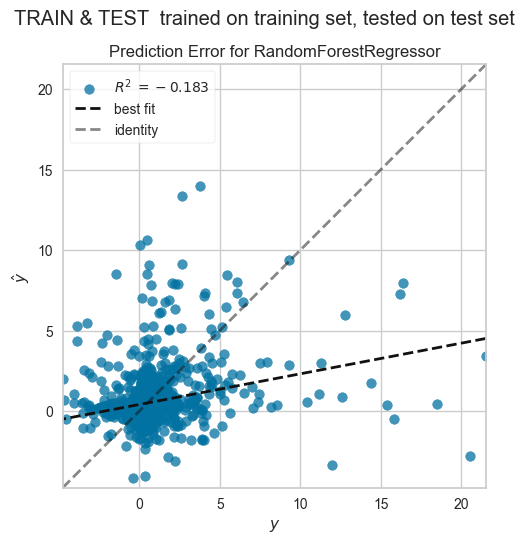

>>> Collecting results, details about training and testing can be accessed by calling .report_traintest().
>>> Done.


In [14]:
rfts.trainmodel(showplot_scores=True, showplot_importance=True)

In [15]:
rfts.report_traintest()


MODEL TRAINING & TESTING RESULTS

## DATA
  > target: FN2O_L3.1_L3.3_CUT_50_QCF
  > features: 32 ['.RECORDNUMBER', 'TIMESINCE_MGMT_FERT_ORG_FOOTPRINT', 'TS_GF1_0.4_1_gfXG_MEAN3H', '.TS_GF1_0.15_1_gfXG_MEAN3H-24', 'TIMESINCE_MGMT_FERT_MIN_FOOTPRINT', '.TS_GF1_0.04_1_gfXG_MEAN3H-6', 'TIMESINCE_MGMT_SOWING_FOOTPRINT', '.TS_GF1_0.15_1_gfXG_MEAN3H-6', '.SWC_GF1_0.15_1_gfXG_MEAN3H-6', '.TS_GF1_0.04_1_gfXG_MEAN3H-18', 'TIMESINCE_MGMT_MOWING_FOOTPRINT', '.TS_GF1_0.4_1_gfXG_MEAN3H-6', 'TIMESINCE_MGMT_GRAZING_FOOTPRINT', 'TIMESINCE_PREC_RAIN_TOT_GF1_0.5_1', '.TS_GF1_0.04_1_gfXG_MEAN3H-12', '.SWC_GF1_0.15_1_gfXG_MEAN3H-24', 'TIMESINCE_MGMT_SOILCULTIVATION_FOOTPRINT', '.TS_GF1_0.4_1_gfXG_MEAN3H-12', '.TS_GF1_0.4_1_gfXG_MEAN3H-24', '.TS_GF1_0.4_1_gfXG_MEAN3H-18', '.SWC_GF1_0.15_1_gfXG_MEAN3H-12', '.TS_GF1_0.04_1_gfXG-1', '.SWC_GF1_0.15_1_gfXG_MEAN3H-18', '.SWC_GF1_0.15_1_gfXG-1', '.DOY', 'TS_GF1_0.04_1_gfXG_MEAN3H', '.TS_GF1_0.15_1_gfXG_MEAN3H-12', 'TIMESINCE_MGMT_PESTICIDE_HERBICIDE_FOOTPRINT', '

</br>

## Apply model to fill gaps


Gap-filling using final model ...
>>> Using final model on all data to predict target FN2O_L3.1_L3.3_CUT_50_QCF ...
>>> Using final model on all data to calculate permutation importance ...
>>> Plotting feature importances (permutation importance) ...
>>> Calculating prediction scores based on all data predicting FN2O_L3.1_L3.3_CUT_50_QCF ...
>>> Plotting observed and predicted values based on all data ...


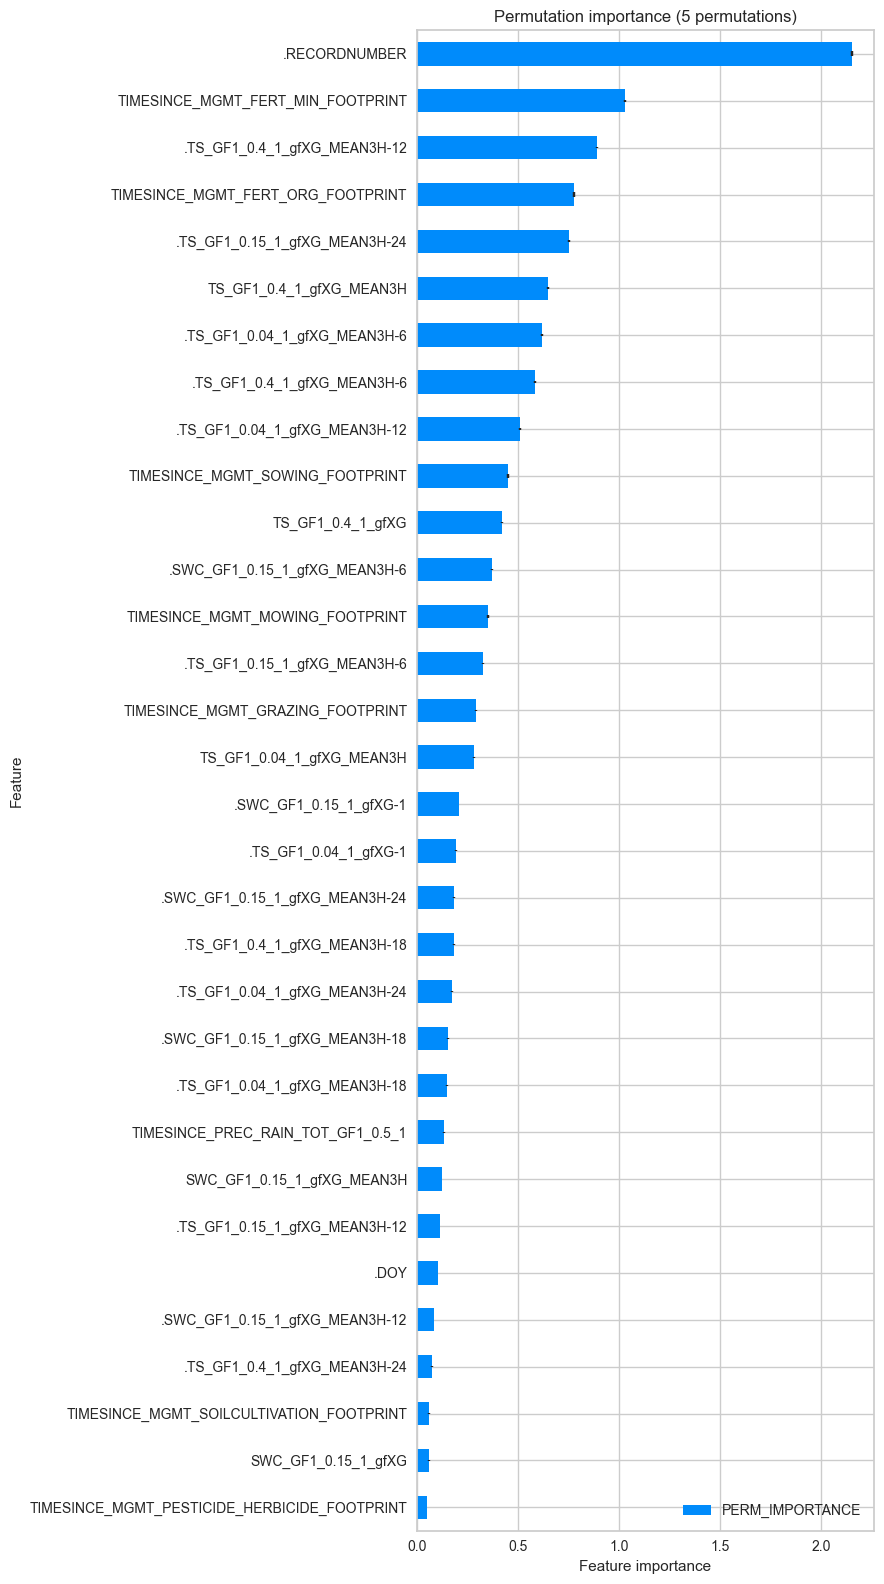

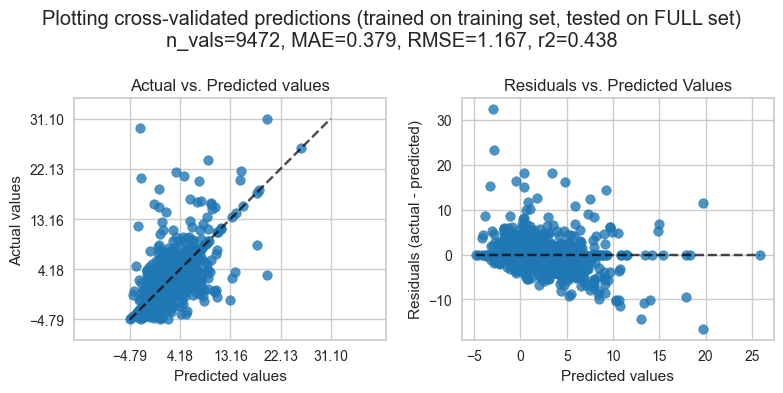

>>> Predicting target FN2O_L3.1_L3.3_CUT_50_QCF where all features are available ... predicted 52608 records.
>>> Collecting results for final model ...
>>> Filling 43136 missing records in target with predictions from final model ...
>>> Storing gap-filled time series in variable FN2O_L3.1_L3.3_CUT_50_QCF_gfRF ...
>>> Restoring original timestamp in results ...

Gap-filling 0 remaining missing records in FN2O_L3.1_L3.3_CUT_50_QCF_gfRF using fallback model ...
>>> Fallback model not necessary, all gaps were already filled.
>>> Combining predictions from full model and fallback model ...


In [16]:
rfts.fillgaps(showplot_scores=True, showplot_importance=True)

In [17]:
rfts.report_gapfilling()


GAP-FILLING RESULTS

Model scores and feature importances were calculated from high-quality predicted targets (43136 values, FN2O_L3.1_L3.3_CUT_50_QCF_gfRF where flag=1) in comparison to observed targets (9472 values, FN2O_L3.1_L3.3_CUT_50_QCF).

## TARGET
- first timestamp:  2016-01-01 00:15:00
- last timestamp:  2018-12-31 23:45:00
- potential number of values: 52608 values)
- target column (observed):  FN2O_L3.1_L3.3_CUT_50_QCF
- missing records (observed):  43136 (cross-check from flag: 43136)
- target column (gap-filled):  FN2O_L3.1_L3.3_CUT_50_QCF_gfRF  (52608 values)
- missing records (gap-filled):  0
- gap-filling flag: FLAG_FN2O_L3.1_L3.3_CUT_50_QCF_gfRF_ISFILLED
  > flag 0 ... observed targets (9472 values)
  > flag 1 ... targets gap-filled with high-quality, all features available (43136 values)
  > flag 2 ... targets gap-filled with fallback (0 values)

## FEATURE IMPORTANCES
- names of features used in model:  ['.RECORDNUMBER', 'TIMESINCE_MGMT_FERT_MIN_FOOTPRINT', '.TS_GF

</br>

## Attributes
A lot more information about feature reduction, training and testing, model building and gap-filling is available via the class attributes.

In [18]:
rfts.feature_importances_

,PERM_IMPORTANCE,PERM_SD
.RECORDNUMBER,2.155473,0.052304
TIMESINCE_MGMT_FERT_MIN_FOOTPRINT,1.030551,0.024922
.TS_GF1_0.4_1_gfXG_MEAN3H-12,0.892976,0.017564
TIMESINCE_MGMT_FERT_ORG_FOOTPRINT,0.778673,0.055788
.TS_GF1_0.15_1_gfXG_MEAN3H-24,0.751478,0.021275
TS_GF1_0.4_1_gfXG_MEAN3H,0.648268,0.020283
.TS_GF1_0.04_1_gfXG_MEAN3H-6,0.618678,0.021577
.TS_GF1_0.4_1_gfXG_MEAN3H-6,0.585653,0.021225
.TS_GF1_0.04_1_gfXG_MEAN3H-12,0.508663,0.019810
TIMESINCE_MGMT_SOWING_FOOTPRINT,0.448270,0.037940


In [19]:
rfts.feature_importances_reduction_

,PERM_IMPORTANCE,PERM_SD
.RECORDNUMBER,1.108052,0.051654
TIMESINCE_MGMT_FERT_ORG_FOOTPRINT,0.864362,0.026744
TS_GF1_0.4_1_gfXG_MEAN3H,0.739505,0.034418
.TS_GF1_0.15_1_gfXG_MEAN3H-24,0.677102,0.020291
TIMESINCE_MGMT_FERT_MIN_FOOTPRINT,0.556564,0.048287
...,...,...
.SEASON,0.001736,0.000279
.PREC_RAIN_TOT_GF1_0.5_1-1,0.001285,0.000030
.WEEK,0.000235,0.001441
.MONTH,0.000149,0.000029


In [20]:
rfts.feature_importances_traintest_

,PERM_IMPORTANCE,PERM_SD
.RECORDNUMBER,1.846101,0.118563
TIMESINCE_MGMT_FERT_MIN_FOOTPRINT,0.871464,0.050880
.TS_GF1_0.15_1_gfXG_MEAN3H-24,0.672604,0.058819
.TS_GF1_0.4_1_gfXG_MEAN3H-12,0.649994,0.022806
TS_GF1_0.4_1_gfXG_MEAN3H,0.625297,0.050523
TIMESINCE_MGMT_FERT_ORG_FOOTPRINT,0.623099,0.069851
.TS_GF1_0.4_1_gfXG_MEAN3H-6,0.549497,0.037099
.TS_GF1_0.04_1_gfXG_MEAN3H-12,0.525203,0.039365
.TS_GF1_0.04_1_gfXG_MEAN3H-6,0.406083,0.036784
TIMESINCE_MGMT_SOWING_FOOTPRINT,0.377934,0.040240


In [21]:
rfts.gapfilling_df_

,.PREDICTIONS_FULLMODEL,FN2O_L3.1_L3.3_CUT_50_QCF,.GAP_PREDICTIONS,FLAG_FN2O_L3.1_L3.3_CUT_50_QCF_gfRF_ISFILLED,FN2O_L3.1_L3.3_CUT_50_QCF_gfRF,.PREDICTIONS_FALLBACK,.GAPFILLED_CUMULATIVE,.PREDICTIONS
TIMESTAMP_MIDDLE,,,,,,,,
2016-01-01 00:15:00,1.307964,NaN,1.307964,1,1.307964,None,1.307964,1.307964
2016-01-01 00:45:00,1.307964,NaN,1.307964,1,1.307964,None,2.615929,1.307964
2016-01-01 01:15:00,2.556259,NaN,2.556259,1,2.556259,None,5.172188,2.556259
2016-01-01 01:45:00,2.556259,0.275746,NaN,0,0.275746,None,5.447934,2.556259
2016-01-01 02:15:00,1.307964,NaN,1.307964,1,1.307964,None,6.755898,1.307964
...,...,...,...,...,...,...,...,...
2018-12-31 21:45:00,0.482722,NaN,0.482722,1,0.482722,None,70581.248757,0.482722
2018-12-31 22:15:00,0.544081,NaN,0.544081,1,0.544081,None,70581.792837,0.544081
2018-12-31 22:45:00,0.544081,NaN,0.544081,1,0.544081,None,70582.336918,0.544081


In [22]:
rfts.model_

RandomForestRegressor(n_estimators=3, n_jobs=-1, random_state=42)

In [23]:
rfts.accepted_features_

['.RECORDNUMBER',
 'TIMESINCE_MGMT_FERT_ORG_FOOTPRINT',
 'TS_GF1_0.4_1_gfXG_MEAN3H',
 '.TS_GF1_0.15_1_gfXG_MEAN3H-24',
 'TIMESINCE_MGMT_FERT_MIN_FOOTPRINT',
 '.TS_GF1_0.04_1_gfXG_MEAN3H-6',
 'TIMESINCE_MGMT_SOWING_FOOTPRINT',
 '.TS_GF1_0.15_1_gfXG_MEAN3H-6',
 '.SWC_GF1_0.15_1_gfXG_MEAN3H-6',
 '.TS_GF1_0.04_1_gfXG_MEAN3H-18',
 'TIMESINCE_MGMT_MOWING_FOOTPRINT',
 '.TS_GF1_0.4_1_gfXG_MEAN3H-6',
 'TIMESINCE_MGMT_GRAZING_FOOTPRINT',
 'TIMESINCE_PREC_RAIN_TOT_GF1_0.5_1',
 '.TS_GF1_0.04_1_gfXG_MEAN3H-12',
 '.SWC_GF1_0.15_1_gfXG_MEAN3H-24',
 'TIMESINCE_MGMT_SOILCULTIVATION_FOOTPRINT',
 '.TS_GF1_0.4_1_gfXG_MEAN3H-12',
 '.TS_GF1_0.4_1_gfXG_MEAN3H-24',
 '.TS_GF1_0.4_1_gfXG_MEAN3H-18',
 '.SWC_GF1_0.15_1_gfXG_MEAN3H-12',
 '.TS_GF1_0.04_1_gfXG-1',
 '.SWC_GF1_0.15_1_gfXG_MEAN3H-18',
 '.SWC_GF1_0.15_1_gfXG-1',
 '.DOY',
 'TS_GF1_0.04_1_gfXG_MEAN3H',
 '.TS_GF1_0.15_1_gfXG_MEAN3H-12',
 'TIMESINCE_MGMT_PESTICIDE_HERBICIDE_FOOTPRINT',
 'TS_GF1_0.4_1_gfXG',
 '.TS_GF1_0.04_1_gfXG_MEAN3H-24',
 'SWC_GF1_0.15_1

In [24]:
rfts.rejected_features_

['TS_GF1_0.04_1_gfXG',
 'TS_GF1_0.15_1_gfXG',
 'PREC_RAIN_TOT_GF1_0.5_1',
 'TS_GF1_0.15_1_gfXG_MEAN3H',
 '.TS_GF1_0.15_1_gfXG_MEAN3H-18',
 'PREC_RAIN_TOT_GF1_0.5_1_MEAN3H',
 '.PREC_RAIN_TOT_GF1_0.5_1_MEAN3H-24',
 '.PREC_RAIN_TOT_GF1_0.5_1_MEAN3H-18',
 '.PREC_RAIN_TOT_GF1_0.5_1_MEAN3H-12',
 '.PREC_RAIN_TOT_GF1_0.5_1_MEAN3H-6',
 '.TS_GF1_0.15_1_gfXG-1',
 '.TS_GF1_0.4_1_gfXG-1',
 '.PREC_RAIN_TOT_GF1_0.5_1-1',
 '.YEAR',
 '.SEASON',
 '.MONTH',
 '.WEEK',
 '.HOUR',
 '.YEARMONTH',
 '.YEARDOY',
 '.YEARWEEK']

In [25]:
rfts.scores_

{'mae': np.float64(0.37902878912883203),
 'medae': np.float64(0.07286768000000005),
 'mse': np.float64(1.3622259561435226),
 'rmse': np.float64(1.1671443595988984),
 'mape': np.float64(1.286976028535933),
 'maxe': np.float64(32.337875000000004),
 'r2': 0.43812510515541936}

In [26]:
rfts.scores_traintest_

{'mae': np.float64(0.7092466025150873),
 'medae': np.float64(0.20407489),
 'mse': np.float64(2.9554977590046776),
 'rmse': np.float64(1.7191561182756723),
 'mape': np.float64(2.192056382002906),
 'maxe': np.float64(23.3504434),
 'r2': -0.18259949617733073}

In [27]:
rfts.traintest_details_.keys()

dict_keys(['train_df', 'test_df', 'test_size', 'X_names', 'model'])

</br>

## Result

In [28]:
gapfilled = rfts.get_gapfilled_target()
gapfilled

TIMESTAMP_MIDDLE
2016-01-01 00:15:00    1.307964
2016-01-01 00:45:00    1.307964
2016-01-01 01:15:00    2.556259
2016-01-01 01:45:00    0.275746
2016-01-01 02:15:00    1.307964
                         ...   
2018-12-31 21:45:00    0.482722
2018-12-31 22:15:00    0.544081
2018-12-31 22:45:00    0.544081
2018-12-31 23:15:00    0.544081
2018-12-31 23:45:00    0.544081
Freq: 30min, Name: FN2O_L3.1_L3.3_CUT_50_QCF_gfRF, Length: 52608, dtype: float64

In [29]:
flag = rfts.get_flag()
flag

TIMESTAMP_MIDDLE
2016-01-01 00:15:00    1
2016-01-01 00:45:00    1
2016-01-01 01:15:00    1
2016-01-01 01:45:00    0
2016-01-01 02:15:00    1
                      ..
2018-12-31 21:45:00    1
2018-12-31 22:15:00    1
2018-12-31 22:45:00    1
2018-12-31 23:15:00    1
2018-12-31 23:45:00    1
Freq: 30min, Name: FLAG_FN2O_L3.1_L3.3_CUT_50_QCF_gfRF_ISFILLED, Length: 52608, dtype: int64

In [30]:
gapfilling_df = rfts.gapfilling_df_
gapfilling_df

,.PREDICTIONS_FULLMODEL,FN2O_L3.1_L3.3_CUT_50_QCF,.GAP_PREDICTIONS,FLAG_FN2O_L3.1_L3.3_CUT_50_QCF_gfRF_ISFILLED,FN2O_L3.1_L3.3_CUT_50_QCF_gfRF,.PREDICTIONS_FALLBACK,.GAPFILLED_CUMULATIVE,.PREDICTIONS
TIMESTAMP_MIDDLE,,,,,,,,
2016-01-01 00:15:00,1.307964,NaN,1.307964,1,1.307964,None,1.307964,1.307964
2016-01-01 00:45:00,1.307964,NaN,1.307964,1,1.307964,None,2.615929,1.307964
2016-01-01 01:15:00,2.556259,NaN,2.556259,1,2.556259,None,5.172188,2.556259
2016-01-01 01:45:00,2.556259,0.275746,NaN,0,0.275746,None,5.447934,2.556259
2016-01-01 02:15:00,1.307964,NaN,1.307964,1,1.307964,None,6.755898,1.307964
...,...,...,...,...,...,...,...,...
2018-12-31 21:45:00,0.482722,NaN,0.482722,1,0.482722,None,70581.248757,0.482722
2018-12-31 22:15:00,0.544081,NaN,0.544081,1,0.544081,None,70581.792837,0.544081
2018-12-31 22:45:00,0.544081,NaN,0.544081,1,0.544081,None,70582.336918,0.544081


</br>

## Plot

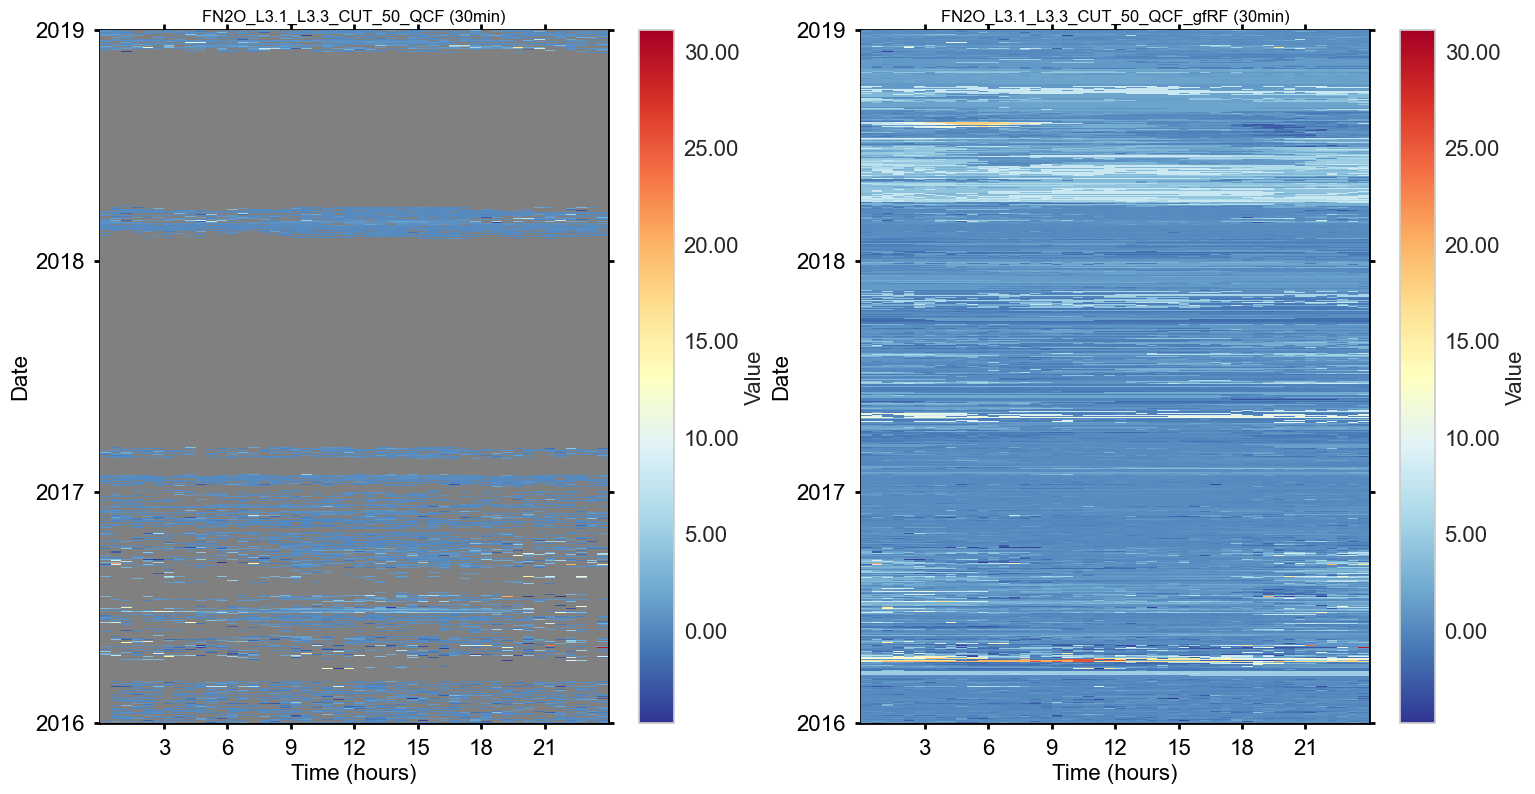

In [32]:
fig, axs = plt.subplots(ncols=2, figsize=(18, 9))
HeatmapDateTime(series=subset[TARGET_COL], ax=axs[0]).plot()
HeatmapDateTime(series=gapfilled, ax=axs[1]).plot()

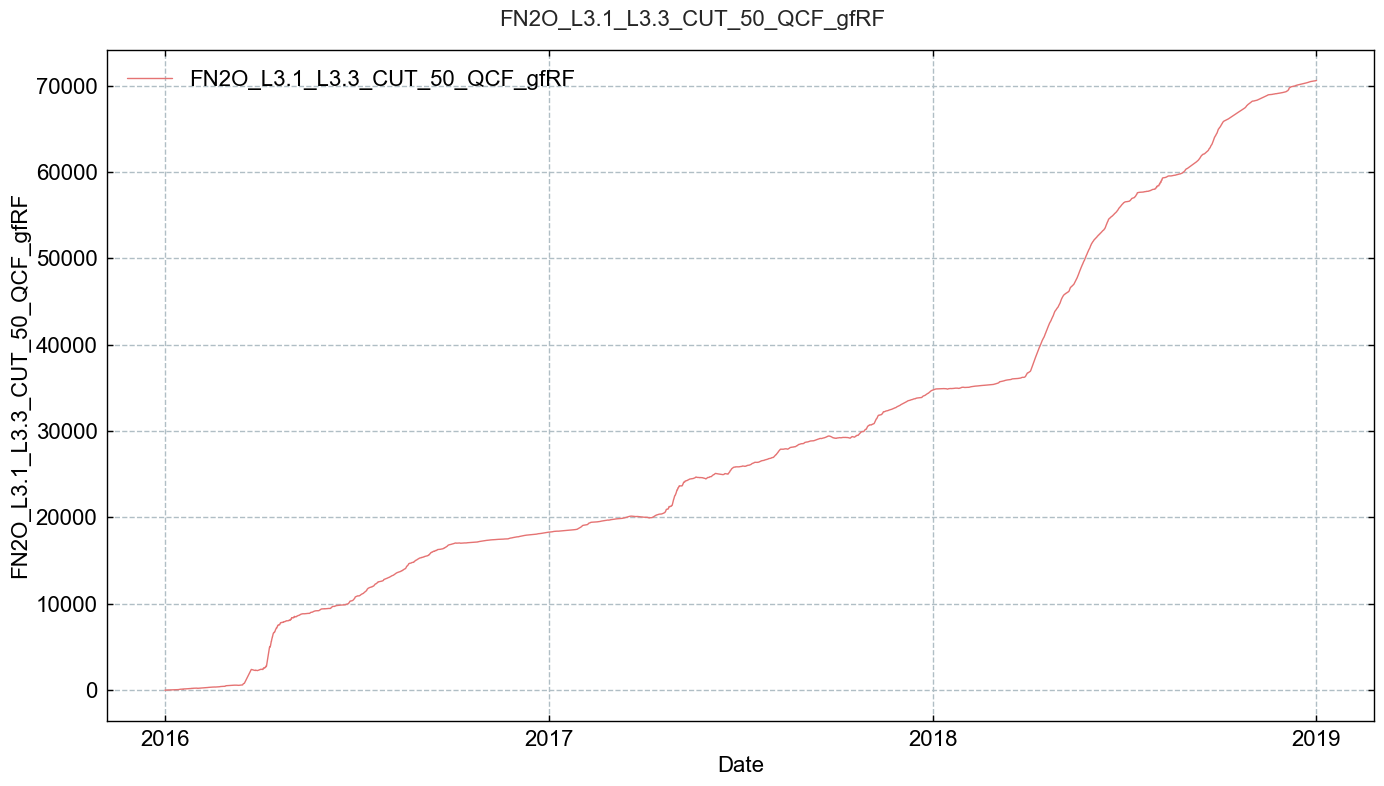

In [33]:
TimeSeries(series=gapfilled.cumsum()).plot()

# **Save to file**

In [36]:
# TODO!
suffix = "N2O"
outfile = f"51.3_FluxProcessingChain_L4.1_{suffix}"
fpc.fpc_df.to_csv(f"{outfile}.csv")  # large file, slow to read
save_parquet(data=fpc.fpc_df, filename=f"{outfile}")  # Smaller file, very fast to read

NameError: name 'fpc' is not defined

# **End of notebook**
Congratulations, you reached the end of this notebook! Before you go let's store your finish time.

In [ ]:
dt_string = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
print(f"Finished. {dt_string}")